In [ ]:
!nvidia-smi

Mon Aug 10 17:17:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/NVIDIA/apex /apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
datasets  models  test.zip  train-eval.ipynb  trainval.zip


In [3]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d "/content"
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp single-shot-detection-pytorch/*.py .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 89 (delta 52), reused 60 (delta 25), pack-reused 0
Unpacking objects: 100% (89/89), done.
     |████████████████████████████████| 122kB 8.3MB/s 
     |████████████████████████████████| 952kB 14.6MB/s 


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.cuda as cuda
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from dataset import VOCDataset, collate_fn
from model import SSD300, MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint, calculate_mAP

In [ ]:
#from apex import amp

## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')


There are 17202 training images. Files have been saved to output_folder: datasets/.

There are 4301 validation images. Files have been saved to output_folder: datasets/.


In [ ]:
!ls datasets/

In [ ]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'))

dataloaders = dict(
    train = DataLoader(trainset, batch_size=16, collate_fn=collate_fn, shuffle=True, num_workers=2),
    val = DataLoader(valset, batch_size=64, collate_fn=collate_fn, shuffle=False, num_workers=4),
)

### EDA

In [ ]:
def visualize_objects_stat(dataset):
    targets = dataset.targets
    objects = list()
    for target in targets:
        objects.extend(target['labels'])
    print('Total number of annotated objects:', len(objects))
    sns.countplot(objects)

In [ ]:
label_map

{'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20,
 'background': 0}

Total number of annotated objects: 49949


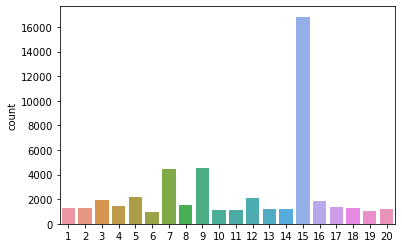

In [ ]:
visualize_objects_stat(trainset)

Total number of annotated objects: 12250


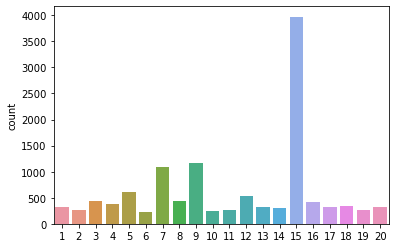

In [ ]:
visualize_objects_stat(valset)

## Train model

In [ ]:
device = torch.device("cuda" if cuda.is_available() else "cpu") 

checkpoint_path = gdrive_dir+'models/checkpoint_ssd300.pt'
checkpoint = torch.load(checkpoint_path)
vgg16_dir = 'models/'

MySSD300 = SSD300(n_classes=21, vgg16_dir=vgg16_dir, checkpoint=checkpoint).to(device)

loss_func = MultiBoxLoss(priors_cxcy=MySSD300.get_prior_boxes(), threshold=0.5, neg_pos_ratio=3, alpha=1.)

optimizer = torch.optim.Adam(MySSD300.parameters(), lr=1e-3, weight_decay=5e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.987, last_epoch=-1)

grad_clip = None

# Mixed precision
#MySSD300, optimizer = amp.initialize(MySSD300, optimizer, opt_level='O1')
#if checkpoint: amp.load_state_dict(checkpoint['amp'])

In [ ]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels,_) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 100 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item()/trainset_loader.batch_size:.4f}')
        
        train_loss += loss.item()
        
    return train_loss/len(trainset)

def eval_epoch(model, valset_loader, loss_func):
    '''
    '''
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels,_) in enumerate(valset_loader):
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return val_loss/len(valset)


def train_model(model, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=1, checkpoint=None):
    last_epoch = 0
    if checkpoint:
        last_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer'])
        exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.987, last_epoch=last_epoch)

    train_loss_hist, val_loss_hist = [], []
    for i in range(last_epoch+1, last_epoch+n_epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, i)
        exp_lr_scheduler.step()
        training_time = round(time.time() - start_time)
        
        save_checkpoint(epoch, model, optimizer, checkpoint_path)
        
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func)
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {i} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}')
        
    return train_loss_hist, val_loss_hist

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=30)

Epoch 1 - step 0: train_loss: 2.8963
Epoch 1 - step 100: train_loss: 0.3581
Epoch 1 - step 200: train_loss: 0.3429
Epoch 1 - step 300: train_loss: 0.3395
Epoch 1 - step 400: train_loss: 0.3645
Epoch 1 - step 500: train_loss: 0.3173
Epoch 1 - step 600: train_loss: 0.3783
Epoch 1 - step 700: train_loss: 0.3241
Epoch 1 - step 800: train_loss: 0.3415
Epoch 1 - step 900: train_loss: 0.3448
Epoch 1 - step 1000: train_loss: 0.3452
Epoch 1 - train/val_time: 661s | 60s - train_loss: 0.3622 - val_loss: 0.0883
Epoch 2 - train/val_time: 662s | 61s - train_loss: 0.3346 - val_loss: 0.0827
Epoch 3 - train/val_time: 661s | 61s - train_loss: 0.3203 - val_loss: 0.0792
Epoch 4 - train/val_time: 666s | 61s - train_loss: 0.3089 - val_loss: 0.0776
Epoch 5 - train/val_time: 660s | 61s - train_loss: 0.2981 - val_loss: 0.0762
Epoch 6 - train/val_time: 662s | 60s - train_loss: 0.2891 - val_loss: 0.0714
Epoch 7 - train/val_time: 660s | 61s - train_loss: 0.2819 - val_loss: 0.0692
Epoch 8 - train/val_time: 658s | 

In [ ]:
train_hist, val_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, n_epoch=30, checkpoint=checkpoint)

## Evaluate

In [ ]:
def eval_APs_mAP(model, valset_loader):
    '''
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_diffs = list()
    
    start_time = time.time()
    with torch.no_grad():
        for step, (imgs, boxes, labels, diffs) in enumerate(valset_loader):
            # move input data to GPU
            #imgs = imgs.to(device)
            #boxes = [b.to(device) for b in boxes]
            #labels = [l.to(device) for l in labels]
            #diffs = [d.to(device) for d in diffs]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.detect_objects(predicted_offsets, predicted_scores,
                                                                                       score_threshold=0.01, iou_threshold=0.5)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            #true_diffs.extend(diffs)
            
            if step == 4: 
                print(f'Evaluating on 64*5 = 320 images - Done in {time.time()-start_time}s')
                break

        # calculate metrics value
        APs, mAP = calculate_mAP(detected_boxes, detected_labels, detected_scores, true_boxes, true_labels)
    
    return APs, mAP

In [ ]:
APs, mAP = eval_APs_mAP(MySSD300, dataloaders['val'])